In [1]:
!nvidia-smi

Fri Jun 18 14:28:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#!7z x /content/gdrive/MyDrive/Deep\ Learning/archive.zip

import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/plant disease identification dataset (updated).zip",'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
!pip install torchsummary

In [4]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

#from ray import tune
#from ray.tune import CLIReporter
#from ray.tune.schedulers import ASHAScheduler

%matplotlib inline

In [5]:
!pip install mlflow

     |████████████████████████████████| 14.2MB 7.7MB/s 
     |████████████████████████████████| 1.1MB 51.1MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 645kB 62.2MB/s 
     |████████████████████████████████| 174kB 57.3MB/s 
     |████████████████████████████████| 153kB 56.9MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158170 sha256=0faa84a3e1e121190217a25d7d9a50f0cb83ad5c05bec1121c1e58e333227671
  Stored in directory: /root/.cache/pip/wheels/84/07/f7/12f7370ca47a66030c2edeedcc23dec26ea0ac22dcb4c4a0f3
  Created wheel for prometheus-flask-exporter: filename=prometheus_flask_exporter-0.18.2-cp37-none-any.whl size=17415 sha256=98598c1941f34c357801bb99a0e94e50bf5174eb7ee4d82f0618ac5d8

In [6]:
import mlflow
import mlflow.pytorch

## Data Load

In [7]:
data_dir = "plant disease identification dataset (updated)"
diseases = os.listdir(data_dir)
print(diseases)

['Apple___healthy', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Grape___Black_rot', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Leaf_Mold', 'Tomato___Tomato_mosaic_virus', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Strawberry___healthy', 'Grape___healthy', 'Corn_(maize)___Common_rust_', 'Raspberry___healthy', 'Apple___Apple_scab', 'Peach___Bacterial_spot', 'Pepper,_bell___Bacterial_spot', 'Strawberry___Leaf_scorch', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Squash___Powdery_mildew', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___healthy', 'Pepper,_bell___healthy', 'Tomato___healthy', 'Blueberry___healthy', 'Grape___Esca_(Black_Measles)', 'Soybean___healthy', 'Potato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Late_blight', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Bacterial_spot', 'Cherry_(including_sour)___heal

In [8]:
print("Total disease classes are:", len(diseases))

Total disease classes are: 38


In [9]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [10]:
# unique plants in the dataset
print(f"Unique Plants are: {len(plants)} \n{plants}")

print("Number of diseases: {}".format(NumberOfDiseases))

Unique Plants are: 14 
['Apple', 'Grape', 'Potato', 'Tomato', 'Orange', 'Strawberry', 'Corn_(maize)', 'Raspberry', 'Peach', 'Pepper,_bell', 'Squash', 'Cherry_(including_sour)', 'Blueberry', 'Soybean']
Number of diseases: 26


In [11]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(data_dir+'/'+ disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
print(img_per_class)

                                                    no. of images
Apple___healthy                                              2510
Apple___Black_rot                                            2484
Apple___Cedar_apple_rust                                     2204
Grape___Black_rot                                            2360
Potato___Late_blight                                         2424
Potato___healthy                                             2282
Tomato___Leaf_Mold                                           2352
Tomato___Tomato_mosaic_virus                                 2238
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   2152
Tomato___Septoria_leaf_spot                                  2181
Tomato___Target_Spot                                         2284
Orange___Haunglongbing_(Citrus_greening)                     2513
Strawberry___healthy                                         2280
Grape___healthy                                              2115
Corn_(maiz

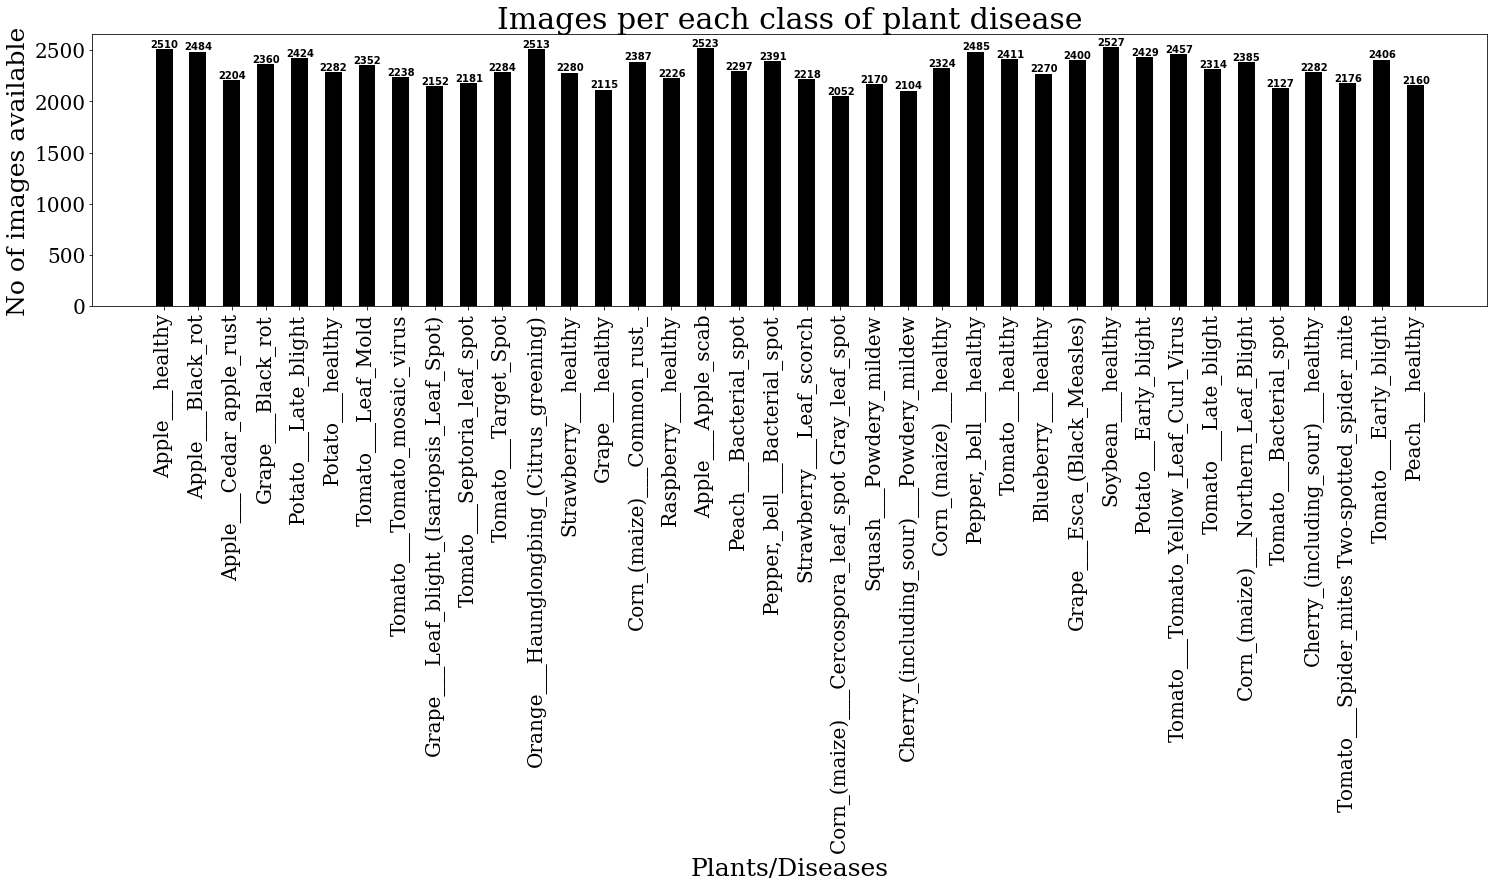

In [12]:
# plotting number of images available for each disease
from matplotlib import rc
index = [n for n in range(38)]
plt.figure(figsize=(25, 5))
plt.bar(index, [n for n in nums.values()], width=0.5, color = ['black'])
#rc('font',**{'family':'serif','serif':['Times']})
plt.xlabel('Plants/Diseases', fontsize=25, fontname = 'serif')
plt.ylabel('No of images available', fontsize=25, fontname = 'serif')
plt.xticks(index, diseases, fontsize=20, fontname = 'serif',rotation=90)
plt.yticks(fontsize = 20, fontname = 'serif')
plt.title('Images per each class of plant disease', fontsize = 30, fontname = 'serif')
for i, v in enumerate(nums.values()):

    plt.text( i-0.4,v+20, str(v), fontweight = 'bold')

In [13]:
total_imgs = img_per_class["no. of images"].sum()
print(f"There are {total_imgs} images")

In [14]:
siz = 224
transform1 = transforms.Compose([transforms.Resize(siz),transforms.ToTensor()])
data = ImageFolder(data_dir, transform=transform1)
data.classes

There are 87900 images


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [15]:
img, label = data[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


In [16]:
len(data.classes)

38

In [17]:
# for checking some images from dataset
def show_image(image, label):
    print("Label: " + data.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label: Apple___Apple_scab(0)


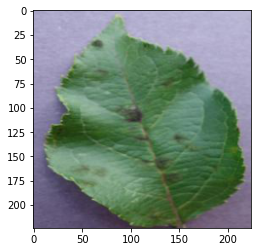

In [18]:
show_image(*data[0])

In [19]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

In [20]:
class Params(object):
    def __init__(self, batch_size, epochs,lr = 0.001,grad_clip = None, weight_decay = 0,
                 momentum = 0.9, opt_func = torch.optim.SGD):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.grad_clip = grad_clip
        self.weight_decay = weight_decay
        self.opt_func = opt_func
        self.momentum = momentum

In [21]:
args = Params(batch_size = 32, epochs = 25)

In [22]:
data_dl = DataLoader(data, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)

## Train test valid split

In [23]:
num_train = int(total_imgs*0.7) +1
num_val = int(total_imgs*0.1)
num_test = int(total_imgs*0.2) 

print(num_train+num_val+num_test)

train_ds, valid_ds, test_ds = torch.utils.data.random_split(data_dl.dataset,(num_train,num_val,num_test))

87900


In [24]:
print(len(train_ds.indices),len(test_ds),len(valid_ds))

61530 17580 8790


In [25]:
print(train_ds.indices[:10] , valid_ds.indices[:10], test_ds.indices[:10])

'''
([50415, 31801, 20841, 12647, 45175, 54352, 30605, 48320, 74316, 57329],
 [52881, 67688, 74955, 29138, 85346, 83961, 63688, 40776, 43841, 72548],
 [13364, 63773, 32184, 81918, 28516, 74071, 25037, 11591, 44989, 19873])
'''

[50415, 31801, 20841, 12647, 45175, 54352, 30605, 48320, 74316, 57329] [52881, 67688, 74955, 29138, 85346, 83961, 63688, 40776, 43841, 72548] [13364, 63773, 32184, 81918, 28516, 74071, 25037, 11591, 44989, 19873]


'\n([50415, 31801, 20841, 12647, 45175, 54352, 30605, 48320, 74316, 57329],\n [52881, 67688, 74955, 29138, 85346, 83961, 63688, 40776, 43841, 72548],\n [13364, 63773, 32184, 81918, 28516, 74071, 25037, 11591, 44989, 19873])\n'

In [ ]:
num_cl = np.zeros((38,), dtype=int)
for img,lb in train_ds:
    num_cl[lb] = num_cl[lb] +1

print(num_cl)


[1758 1761 1556 1758 1625 1490 1549 1393 1699 1670 1636 1640 1663 1520
 1486 1753 1607 1518 1655 1767 1679 1692 1588 1591 1767 1526 1527 1591
 1498 1664 1604 1679 1515 1506 1639 1727 1568 1665]


In [ ]:

num_cl2 = np.zeros((38,), dtype=int)
for img,lb in valid_ds:
    num_cl2[lb] = num_cl2[lb] +1

print(num_cl2)

num_cl3 = np.zeros((38,), dtype=int)
for img,lb in test_ds:
    num_cl3[lb] = num_cl3[lb] +1

print(num_cl3)


[231 232 218 275 205 189 242 216 218 247 235 219 246 217 219 246 221 228
 244 252 243 245 239 206 260 202 243 227 196 259 265 212 224 235 228 229
 225 252]
[534 491 430 477 440 425 491 443 470 468 453 501 491 415 410 514 469 414
 492 466 507 487 455 429 500 442 448 462 433 483 445 461 442 435 417 501
 445 494]


In [ ]:
#plot

In [26]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        print(labels)
        break

In [27]:
train_dl = DataLoader(train_ds, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [28]:
# Images for first batch of training
show_batch(train_dl) 

#34, 18, 30,  1, 29, 23, 17, 27, 22, 11,  6, 20, 36, 23, 33, 25, 10, 30,36, 14, 19, 27, 20, 16,  4, 23, 19, 20, 30, 36, 25,  9]

Output hidden; open in https://colab.research.google.com to view.

In [29]:
print(train_ds)
print(train_dl)

In [30]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl,device)

#Models

## VGG 11 13 16 19

In [ ]:
#VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
# Then flatten and 4096 x 4096 x 38 linear layers

VGG_types = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [ ]:
class VGG_net(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 38):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG16'])

        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
            )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [nn.Conv2d(in_channels = in_channels, 
                                     out_channels = out_channels, 
                                     kernel_size = (3,3), stride = (1,1),
                                     padding = (1,1)), nn.BatchNorm2d(x), 
                           nn.ReLU()]
                in_channels = x
            elif x =='M':
                layers += [nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))]
        return nn.Sequential(*layers)

In [ ]:
model1 = VGG_net(in_channels = 3, num_classes = 38)
x1 = torch.randn(1, 3, 224, 224)
model1(x1)
print(model1(x1).shape)

torch.Size([1, 38])


In [ ]:
# defining the model and moving it to the GPU
model = to_device(VGG_net(3, len(data.classes)), device) 
model

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [ ]:
# getting summary of the model

INPUT_SHAPE = (3, 224, 224)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

## Google Net

In [ ]:
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size = 1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size = 1),
            conv_block(red_3x3, out_3x3, kernel_size = 3, padding = 1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size = 1),
            conv_block(red_5x5, out_5x5, kernel_size = 5, padding = 2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            conv_block(in_channels, out_1x1pool, kernel_size = 1)
        )

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))


In [ ]:
# add GoogleNet here
class GoogleNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 38):
        super(GoogleNet, self).__init__()

        self.conv1 = conv_block(in_channels = in_channels, out_channels = 64, kernel_size = (7,7), stride = (2,2), padding = (3,3))

        self.maxpool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = conv_block(64, 192, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size = 7, stride = 1)
        self.dropout = nn.Dropout(p = 0.4)
        self.fc1 = nn.Linear(1024, 38)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x




In [ ]:
# defining the model and moving it to the GPU
model = to_device(GoogleNet(3, len(data.classes)), device) 
model

GoogleNet(
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): Inception_block(
    (branch1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): conv_block(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size

In [ ]:
# getting summary of the model

INPUT_SHAPE = (3, 224, 224)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
        conv_block-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
       BatchNorm2d-7          [-1, 192, 56, 56]             384
              ReLU-8          [-1, 192, 56, 56]               0
        conv_block-9          [-1, 192, 56, 56]               0
        MaxPool2d-10          [-1, 192, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          12,352
      BatchNorm2d-12           [-1, 64, 28, 28]             128
             ReLU-13           [-1, 64, 28, 28]               0
       conv_block-14           [-1, 64,

## AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, in_channels, 
                 num_classes = 38):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
                    nn.Conv2d(3, 96, kernel_size = 11, stride = 4, padding = 2),
                    nn.ReLU(inplace = True),
                    nn.MaxPool2d(kernel_size = 3, stride = 2),

                    nn.Conv2d(96, 256, kernel_size = 5, stride = 1, padding = 2),
                    nn.ReLU(inplace = True),
                    nn.MaxPool2d(kernel_size = 3, stride = 2),

                    nn.Conv2d(256, 384, kernel_size = 3, stride = 1, padding = 1),
                    nn.ReLU(inplace = True),

                    nn.Conv2d(384, 384, kernel_size = 3, stride = 1, padding = 1),
                    nn.ReLU(inplace = True),

                    nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1),
                    nn.ReLU(inplace = True),

                    nn.MaxPool2d(kernel_size = 3, stride = 2),      
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace = True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),

            nn.Linear(4096, 38),
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.linear(x)

        return x

In [ ]:
# defining the model and moving it to the GPU
model = to_device(AlexNet(3, len(data.classes)), device) 
model

AlexNet(
  (convolutional): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
# getting summary of the model

INPUT_SHAPE = (3, 224, 224)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

##ZFNet

In [ ]:
class ZFNet(nn.Module):
    def __init__(self, num_classes = 38):
        super(ZFNet, self).__init__()

        self.convolutional = nn.Sequential(
                    nn.Conv2d(3, 96, kernel_size = 7, stride = 2, padding = 1),
                    nn.ReLU(inplace = True),
                    nn.MaxPool2d(kernel_size = 3, stride = 2),

                    nn.Conv2d(96, 256, kernel_size = 5, stride = 2, padding = 0),
                    nn.ReLU(inplace = True),
                    nn.MaxPool2d(kernel_size = 3, stride = 2),

                    nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
                    nn.ReLU(inplace = True),

                    nn.Conv2d(512, 1024, kernel_size = 3, stride = 1, padding = 1),
                    nn.ReLU(inplace = True),

                    nn.Conv2d(1024, 512, kernel_size = 3, stride = 1, padding = 1),
                    nn.ReLU(inplace = True),

                    nn.MaxPool2d(kernel_size = 3, stride = 2),      
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 6 * 6, 4096),
            nn.ReLU(inplace = True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),

            nn.Linear(4096, 38),
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.linear(x)

        return x

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ZFNet(3, len(data.classes)), device) 
model

In [ ]:
# getting summary of the model

INPUT_SHAPE = (3, 224, 224)
print(summary(model.cuda(), (INPUT_SHAPE)))

## ResNet 50, 101, 152

In [ ]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size = 1, stride = 1, padding = 0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):  # [3, 4, 6, 3] , image_channels = no. of inputs channels
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        # ResNet layers
        self.layer1 = self._make_layer(block, layers[0], out_channels = 64, stride = 1)
        self.layer2 = self._make_layer(block, layers[1], out_channels = 128, stride = 2)
        self.layer3 = self._make_layer(block, layers[2], out_channels = 256, stride = 2)
        self.layer4 = self._make_layer(block, layers[3], out_channels = 512, stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size = 1,
                                                          stride = stride),
                                                nn.BatchNorm2d(out_channels*4))
            layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
            self.in_channels = out_channels*4  #256

            for i in range(num_residual_blocks - 1):
                layers.append(block(self.in_channels, out_channels)) # out_channels = 256 ->64, 64*4 (256) again

            return nn.Sequential(*layers)

def ResNet50(img_channels = 3, num_classes = 38):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

def ResNet101(img_channels = 3, num_classes = 38):
    return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)

def ResNet152(img_channels = 3, num_classes = 38):
    return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)

def test():
    net = ResNet152()
    x = torch.randn(2, 3, 224, 224)
    y = net(x).to('cuda')
    print(y.shape)

test()

torch.Size([2, 38])


In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet101(3, len(data.classes)), device) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# getting summary of the model

INPUT_SHAPE = (3, 224, 224)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,

## Googlenet pretained on Imagenet

In [ ]:
import torchvision.models as models

In [ ]:
model = models.googlenet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
model.fc = nn.Linear(1024,len(diseases),bias = True)

In [ ]:
model = to_device(model, device) 
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

#ResNet50 pretrained on Imagenet

In [33]:
import torchvision.models as models

In [34]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
model.fc = nn.Linear(2048,len(diseases),bias = True)

In [36]:
model = to_device(model, device) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#ResNet101 pretrained on Imagenet

In [33]:
import torchvision.models as models

In [34]:
model = models.resnet101(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
model.fc = nn.Linear(2048,len(diseases),bias = True)

In [36]:
model = to_device(model, device) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#ResNet152 pretrained on Imagenet

In [33]:
import torchvision.models as models

In [34]:
model = models.resnet152(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
model.fc = nn.Linear(2048,len(diseases),bias = True)

In [36]:
model = to_device(model, device) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#VGG19 pretrained on Imagenet

In [33]:
import torchvision.models as models

In [34]:
model = models.vgg19_bn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [35]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)

In [36]:
model = to_device(model, device) 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#VGG16 pretrained on Imagenet

In [32]:
import torchvision.models as models

In [33]:
model = models.vgg16_bn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [34]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)

In [35]:
model = to_device(model, device) 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#VGG13 pretrained on Imagenet

In [33]:
import torchvision.models as models

In [34]:
model = models.vgg13_bn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [35]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)

In [36]:
model = to_device(model, device) 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#VGG11 pretrained on Imagenet

In [32]:
import torchvision.models as models

In [33]:
model = models.vgg11_bn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [34]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)

In [35]:
model = to_device(model, device) 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

#AlexNet pretrained on Imagenet

In [34]:
import torchvision.models as models

In [35]:
model = models.alexnet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)

In [37]:
model = to_device(model, device) 
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Training and Testing

In [37]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
def training_step(model, batch):
    images, labels = batch
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def validation_step(model, batch):
    images, labels = batch
    out = model(images)                   # Generate prediction
    loss = F.cross_entropy(out, labels)  # Calculate loss
    acc = accuracy(out, labels)          # Calculate accuracy
    return {"val_loss": loss.detach(), "val_accuracy": acc}

def validation_epoch_end(model, outputs,log = False,loss = "loss", accuracy = "accuracy"):
    batch_losses = [x["val_loss"] for x in outputs]
    batch_accuracy = [x["val_accuracy"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
    epoch_accuracy = torch.stack(batch_accuracy).mean()
    if log:
        mlflow.log_metric(loss,epoch_loss.data.item())
        mlflow.log_metric(accuracy,epoch_accuracy.data.item())
    return {"loss": epoch_loss, "accuracy": epoch_accuracy} # Combine accuracies

def epoch_end(model, epoch, result):
    pass
   

In [38]:
%xmode Verbose

Exception reporting mode: Verbose


In [39]:
# for training
@torch.no_grad()
def evaluate(model, val_loader,log = False, loss = "loss", accuracy = "accuracy"):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model,outputs,log,loss,accuracy)


def fit(epochs, lr, model, train_loader, val_loader,  weight_decay=0,grad_clip=None,
        momentum = 0.9, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay,
                         momentum = momentum)
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
       
        for batch in train_loader:
            loss = training_step(model,batch)
            train_losses.append(loss)
            #mlflow.log_metric('training_loss', loss.data.item())
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
        #validation
        result = evaluate(model, val_loader, True, 'val_loss', 'val_accuracy')
        train_result = evaluate(model, train_loader, True, 'train_loss', 'train_accuracy')
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, train_result['loss'], train_result['accuracy'], result['loss'], result['accuracy']))
        #history.append(result.cpu())

        #with tune.checkpoint_dir(epoch) as checkpoint_dir:
            #path = os.path.join(checkpoint_dir, "checkpoint")
            #torch.save((net.state_dict(), optimizer.state_dict()), path)

        #tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
        


In [ ]:
                 
config = {
        
        "lr": tune.loguniform(1e-4, 1e-1),
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(fit, data_dir=data_dir),
    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

test_acc = test_accuracy(best_trained_model, device)
print("Best trial test set accuracy: {}".format(test_acc))

In [40]:
def get_all_preds(model,loader):
    all_preds = torch.tensor([])
    true_lb = torch.tensor([])
    #all_preds = all_preds.cuda()
    #print(all_preds.is_cuda)
    #print(type(all_preds))
    
    for batch in loader:       
        torch.cuda.empty_cache() 
        with torch.no_grad():
            
            images,labels = batch
            preds = model(images)
            
            preds = preds.cpu()
            all_preds = torch.cat((all_preds,preds),dim=0)
            true_lb = torch.cat((true_lb,labels.cpu()),dim=0)

    print(true_lb)
    print(all_preds.argmax(dim=1))      
    return all_preds.argmax(dim=1),true_lb

In [ ]:
%%time
history = [evaluate(model, valid_dl)]
print(history)

[{'loss': tensor(3.6779, device='cuda:0'), 'accuracy': tensor(0.0247)}]
CPU times: user 7.44 s, sys: 1.23 s, total: 8.67 s
Wall time: 14.1 s


In [41]:
from sklearn import metrics

In [42]:
expt_id = mlflow.create_experiment('VGG19_imagenetToPDI_TL')   #VGGNet-11_25,    VGGNet-13_25,  VGGNet-16_25, VGGNet-19_25, GoogleNet(0.001)
mlflow.set_experiment('VGG19_imagenetToPDI_TL')  #Transfer Learning: GoogLeNet_imagenetToPDI_TL, ResNet50_imagenetToPDI_TL, ResNet101_imagenetToPDI_TL, ResNet152_imagenetToPDI_TL, VGG19_imagenetToPDI_TL, VGG16_imagenetToPDI_TL, VGG13_imagenetToPDI_TL, VGG11_imagenetToPDI_TL, AlexNet_imagenetToPDI_TL
args.grad_clip = None
args.weight_decay = 0.003
#args.opt_func = opt_func
#args.momentum = 0.9

for lr in [0.001]:
    for epochs in [12]:
        for momentum in [0.9]:
            #model = to_device(GoogleNet(3, len(data.classes)), device)
            with mlflow.start_run() as run:
                args.epochs = epochs
                args.lr = lr
                args.momentum = momentum
                print("lr:", args.lr, " epochs:", args.epochs, " momentum:", args.momentum)
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
          
                fit(args.epochs, args.lr, model, train_dl, valid_dl, grad_clip=args.grad_clip, weight_decay= args.weight_decay, momentum = args.momentum, opt_func=args.opt_func)

                test_acc = evaluate(model, test_dl,True,'test_loss', 'test_accuracy')
                print(test_acc)
                #save_confusion_matrix(model,test_dl)
            
                data_preds,true_lb = get_all_preds(model,test_dl)

                y_true = true_lb.tolist()
                y_pred = data_preds.tolist()

                # Print the confusion matrix
                #print(metrics.confusion_matrix(y_true, y_pred))

                # Print the precision and recall, among other metrics
                report = metrics.classification_report(y_true, y_pred, digits=3)
                print(report)
                # mlflow.log_metric('f1-score', report['macro avg']['f1-score'])
                mlflow.pytorch.log_model(model, "models")



lr: 0.001  epochs: 12  momentum: 0.9


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [0], train_loss: 0.0178, train_acc: 0.9945, val_loss: 0.0348, val_acc: 0.9883
Epoch [1], train_loss: 0.0043, train_acc: 0.9990, val_loss: 0.0188, val_acc: 0.9940
Epoch [2], train_loss: 0.0018, train_acc: 0.9998, val_loss: 0.0123, val_acc: 0.9965
Epoch [3], train_loss: 0.0010, train_acc: 1.0000, val_loss: 0.0120, val_acc: 0.9969
Epoch [4], train_loss: 0.0009, train_acc: 1.0000, val_loss: 0.0112, val_acc: 0.9974
Epoch [5], train_loss: 0.0007, train_acc: 1.0000, val_loss: 0.0104, val_acc: 0.9974
Epoch [6], train_loss: 0.0008, train_acc: 1.0000, val_loss: 0.0122, val_acc: 0.9967
Epoch [7], train_loss: 0.0008, train_acc: 1.0000, val_loss: 0.0111, val_acc: 0.9974
Epoch [8], train_loss: 0.0011, train_acc: 1.0000, val_loss: 0.0106, val_acc: 0.9974
Epoch [9], train_loss: 0.0010, train_acc: 1.0000, val_loss: 0.0103, val_acc: 0.9978
Epoch [10], train_loss: 0.0008, train_acc: 1.0000, val_loss: 0.0093, val_acc: 0.9978
Epoch [11], train_loss: 0.0068, train_acc: 0.9982, val_loss: 0.0239, val_ac

In [43]:
#!zip -r /content/mlrunsAlexNet_TL_PDI.zip /content/mlruns   
#!zip -r /content/mlrunsVGG11_TL_PDI.zip /content/mlruns   
#!zip -r /content/mlrunsVGG13_TL_PDI.zip /content/mlruns   
#!zip -r /content/mlrunsVGG16_TL_PDI.zip /content/mlruns   
!zip -r /content/mlrunsVGG19_TL_PDI.zip /content/mlruns   
#!zip -r /content/mlrunsResNet152_TL_PDI.zip /content/mlruns   
#!zip -r /content/mlrunsResNet101_TL_PDI.zip /content/mlruns   
#!zip -r /content/mlrunsResNet50_TL_PDI.zip /content/mlruns   
#!zip -r /content/mlrunsGoogleNet_TL_PDI.zip /content/mlruns  

#!zip -r /content/mlrunsGoogleNet_2.zip /content/mlruns   
#!zip -r /content/mlrunsGoogleNet_1.zip /content/mlruns   
#!zip -r /content/mlrunsVGGnet_19_25.zip /content/mlruns
#!zip -r /content/mlrunsVGGnet_16_25.zip /content/mlruns
#!zip -r /content/mlrunsVGGnet_13_25.zip /content/mlruns
#!zip -r /content/mlrunsVGGnet_11_25.zip /content/mlruns

  adding: content/mlruns/ (stored 0%)
  adding: content/mlruns/0/ (stored 0%)
  adding: content/mlruns/0/meta.yaml (deflated 11%)
  adding: content/mlruns/1/ (stored 0%)
  adding: content/mlruns/1/meta.yaml (deflated 9%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/ (stored 0%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/metrics/ (stored 0%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/metrics/val_loss (deflated 55%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/metrics/train_loss (deflated 56%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/metrics/train_accuracy (deflated 61%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/metrics/test_loss (stored 0%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/metrics/val_accuracy (deflated 63%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/metrics/test_accuracy (stored 0%)
  adding: content/mlruns/1/fbcf2282bb764c7b92b0bde58ed352e5/a

In [44]:
#!cp /content/mlrunsAlexNet_TL_PDI.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGG11_TL_PDI.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGG13_TL_PDI.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGG16_TL_PDI.zip /content/gdrive/MyDrive
!cp /content/mlrunsVGG19_TL_PDI.zip /content/gdrive/MyDrive
#!cp /content/mlrunsResNet152_TL_PDI.zip /content/gdrive/MyDrive
#!cp /content/mlrunsResNet101_TL_PDI.zip /content/gdrive/MyDrive
#!cp /content/mlrunsResNet50_TL_PDI.zip /content/gdrive/MyDrive
#!cp /content/mlrunsGoogleNet_TL_PDI.zip /content/gdrive/MyDrive

#!cp /content/mlrunsGoogleNet_2.zip /content/gdrive/MyDrive
#!cp /content/mlrunsGoogleNet_1.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGGnet_11_25.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGGnet_13_25.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGGnet_16_25.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGGnet_19_25.zip /content/gdrive/MyDrive

#saving model using torch

In [ ]:
# torch.save(model.state_dict(), '/content/trainedVGGnet_11_25.pth')
# torch.save(model.state_dict(), '/content/trainedVGGnet_13_25.pth')
#torch.save(model.state_dict(), '/content/trainedVGGnet_16_25.pth')
#torch.save(model.state_dict(), '/content/trainedVGGnet_19_25.pth')
#torch.save(model.state_dict(), '/content/trainedGoogleNet_1.pth')
torch.save(model.state_dict(), '/content/trainedGoogleNet_2.pth')

In [ ]:
# !cp /content/trainedVGGnet_11_25.pth /content/gdrive/MyDrive
# !cp /content/trainedVGGnet_13_25.pth /content/gdrive/MyDrive
#!cp /content/trainedVGGnet_16_25.pth /content/gdrive/MyDrive
#!cp /content/trainedVGGnet_19_25.pth /content/gdrive/MyDrive
#!cp /content/trainedGoogleNet_1.pth /content/gdrive/MyDrive
!cp /content/trainedGoogleNet_2.pth /content/gdrive/MyDrive

In [ ]:
# model4 = to_device(VGG_net(3, len(data.classes)), device)
# model4.load_state_dict(torch.load('/content/trainedVGGnet_11_25.pth'))

#model5 = to_device(VGG_net(3, len(data.classes)), device)
#model5.load_state_dict(torch.load('/content/trainedVGGnet_13_25.pth'))

#model6 = to_device(VGG_net(3, len(data.classes)), device)
#model6.load_state_dict(torch.load('/content/trainedVGGnet_16_25.pth'))

#model7 = to_device(VGG_net(3, len(data.classes)), device)
#model7.load_state_dict(torch.load('/content/trainedVGGnet_19_25.pth'))
#model8 = to_device(GoogleNet(3, len(data.classes)), device)
#model8.load_state_dict(torch.load('/content/trainedGoogleNet_1.pth'))
model9 = to_device(GoogleNet(3, len(data.classes)), device)
model9.load_state_dict(torch.load('/content/trainedGoogleNet_2.pth'))


<All keys matched successfully>

In [ ]:
# model4.eval()
#model5.eval()
#model6.eval()
#model7.eval()
model9.eval()

GoogleNet(
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): Inception_block(
    (branch1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): conv_block(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size

#loading and testing the model saved in mlruns

In [ ]:
!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelResNet50.pth /content

In [ ]:
!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelVGG16.pth /content

In [ ]:
modelresnet50 = torch.load('/content/modelResNet50.pth')  #ResNet50 25 epochs

In [ ]:
modelvgg16 = torch.load('/content/modelVGG16.pth')  #VGG16 25 epochs

In [ ]:
modelvgg16
#modelresnet50

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
train_acc_ = [evaluate(modelvgg50, train_dl)]
print(train_acc_)

[{'loss': tensor(5.4853e-06, device='cuda:0'), 'accuracy': tensor(1.)}]


In [ ]:
test_acc_ = [evaluate(modelvgg50, test_dl)]
print(test_acc_)

[{'loss': tensor(0.0086, device='cuda:0'), 'accuracy': tensor(0.9978)}]


In [ ]:
val_acc_ = [evaluate(modelvgg50, valid_dl)]
print(val_acc_)

[{'loss': tensor(0.0134, device='cuda:0'), 'accuracy': tensor(0.9967)}]


In [ ]:
#!cp /content/gdrive/MyDrive/Dissertation/Saved\ Models/model_25.pth /content
#!cp /content/gdrive/MyDrive/Dissertation/Saved\ Models/model_30.pth /content
#!cp /content/gdrive/MyDrive/Dissertation/Saved\ Models/model_ZFNet_25.pth /content
#!cp /content/gdrive/MyDrive/Dissertation/Saved\ Models/modelVGGNet_11_25.pth /content
#!cp /content/gdrive/MyDrive/Dissertation/Saved\ Models/modelVGG_13_25.pth /content
#!cp /content/gdrive/MyDrive/Dissertation/Saved\ Models/modelVGG_16_25.pth /content
#!cp /content/gdrive/MyDrive/Dissertation/Saved\ Models/modelVGG_19_25.pth /content

In [ ]:
#model2 = torch.load('/content/model_25.pth') #AlexNet 25 epochs
#model3 = torch.load('/content/model_30.pth') #AlexNet 30 epochs
#model4 = torch.load('/content/model_ZFNet_25.pth')  #ZFNet 25 epochs
#model5 = torch.load('/content/modelVGGNet_11_25.pth')  #VGG11 25 epochs
#model6 = torch.load('/content/modelVGG_13_25.pth')  #VGG13 25 epochs
#model7 = torch.load('/content/modelVGG_16_25.pth')  #VGG16 25 epochs
#model8 = torch.load('/content/modelVGG_19_25.pth')  #VGG19 25 epochs

## Confusion Matrix

In [ ]:
def get_all_preds(model,loader):
    all_preds = torch.tensor([])
    true_lb = torch.tensor([])
    #all_preds = all_preds.cuda()
    #print(all_preds.is_cuda)
    #print(type(all_preds))
    
    for batch in loader:       
        torch.cuda.empty_cache() 
        with torch.no_grad():
            
            images,labels = batch
            preds = model(images)
            
            preds = preds.cpu()
            all_preds = torch.cat((all_preds,preds),dim=0)
            true_lb = torch.cat((true_lb,labels.cpu()),dim=0)

    print(true_lb)
    print(all_preds.argmax(dim=1))      
    return all_preds.argmax(dim=1),true_lb

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def save_confusion_matrix(model,loader,img_path):
    data_preds,true_lb = get_all_preds(model,loader)

    stacked = torch.stack(
        (
            true_lb,
            data_preds
        ), dim = 1
    )

    cmt = torch.zeros(38,38,dtype = torch.int32)

    for p in stacked:
        j,k = p.long().tolist()
        cmt[j,k] = cmt[j,k] + 1

    plt.figure(figsize=(19,19))
    plot_confusion_matrix(cmt, data.classes)
    #cd ./mlruns/0 
    #image_path = 'cmt.png'
    plt.savefig(img_path)
    #mlflow.log_artifact(image_path)
    #cd ../..
    #mlflow.pytorch.log_model(model, "models")
    

False
<class 'torch.Tensor'>
tensor([34.,  6., 23.,  ..., 30.,  4.,  3.])
tensor([34,  6, 23,  ..., 30,  4,  3])
Confusion matrix, without normalization
tensor([[533,   0,   0,  ...,   0,   0,   0],
        [  1, 489,   0,  ...,   0,   0,   0],
        [  0,   0, 429,  ...,   0,   0,   0],
        ...,
        [  0,   0,   0,  ..., 499,   0,   0],
        [  0,   0,   0,  ...,   0, 445,   0],
        [  0,   0,   0,  ...,   0,   0, 493]], dtype=torch.int32)


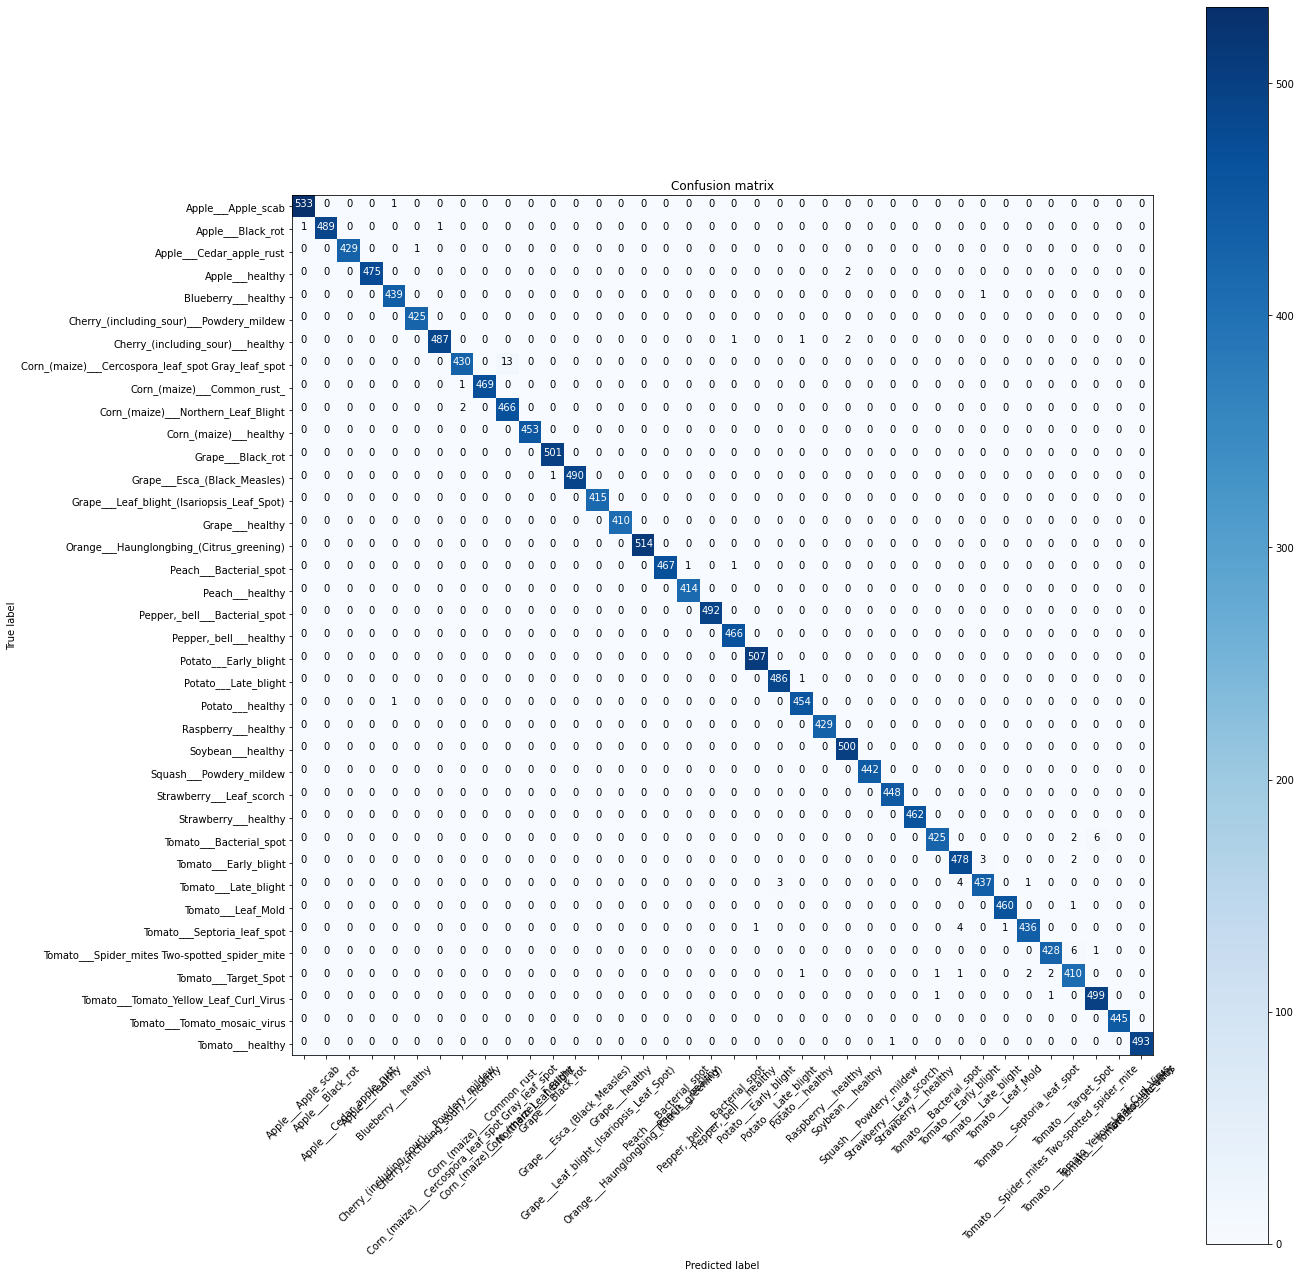

In [ ]:
save_confusion_matrix(model,test_dl)

In [ ]:
data_preds,true_lb = get_all_preds(model,test_dl)

False
<class 'torch.Tensor'>
tensor([ 0., 10., 25.,  ..., 20., 12.,  1.])
tensor([ 0, 10, 25,  ..., 20, 12,  1])


### Plotting Confusion matrix

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

Confusion matrix, without normalization
[[2521    0    0 ...    0    0    0]
 [   0 2484    0 ...    0    0    0]
 [   0    0 2204 ...    0    0    0]
 ...
 [   0    0    0 ... 2454    0    0]
 [   0    0    0 ...    0 2237    0]
 [   0    0    0 ...    0    0 2409]]


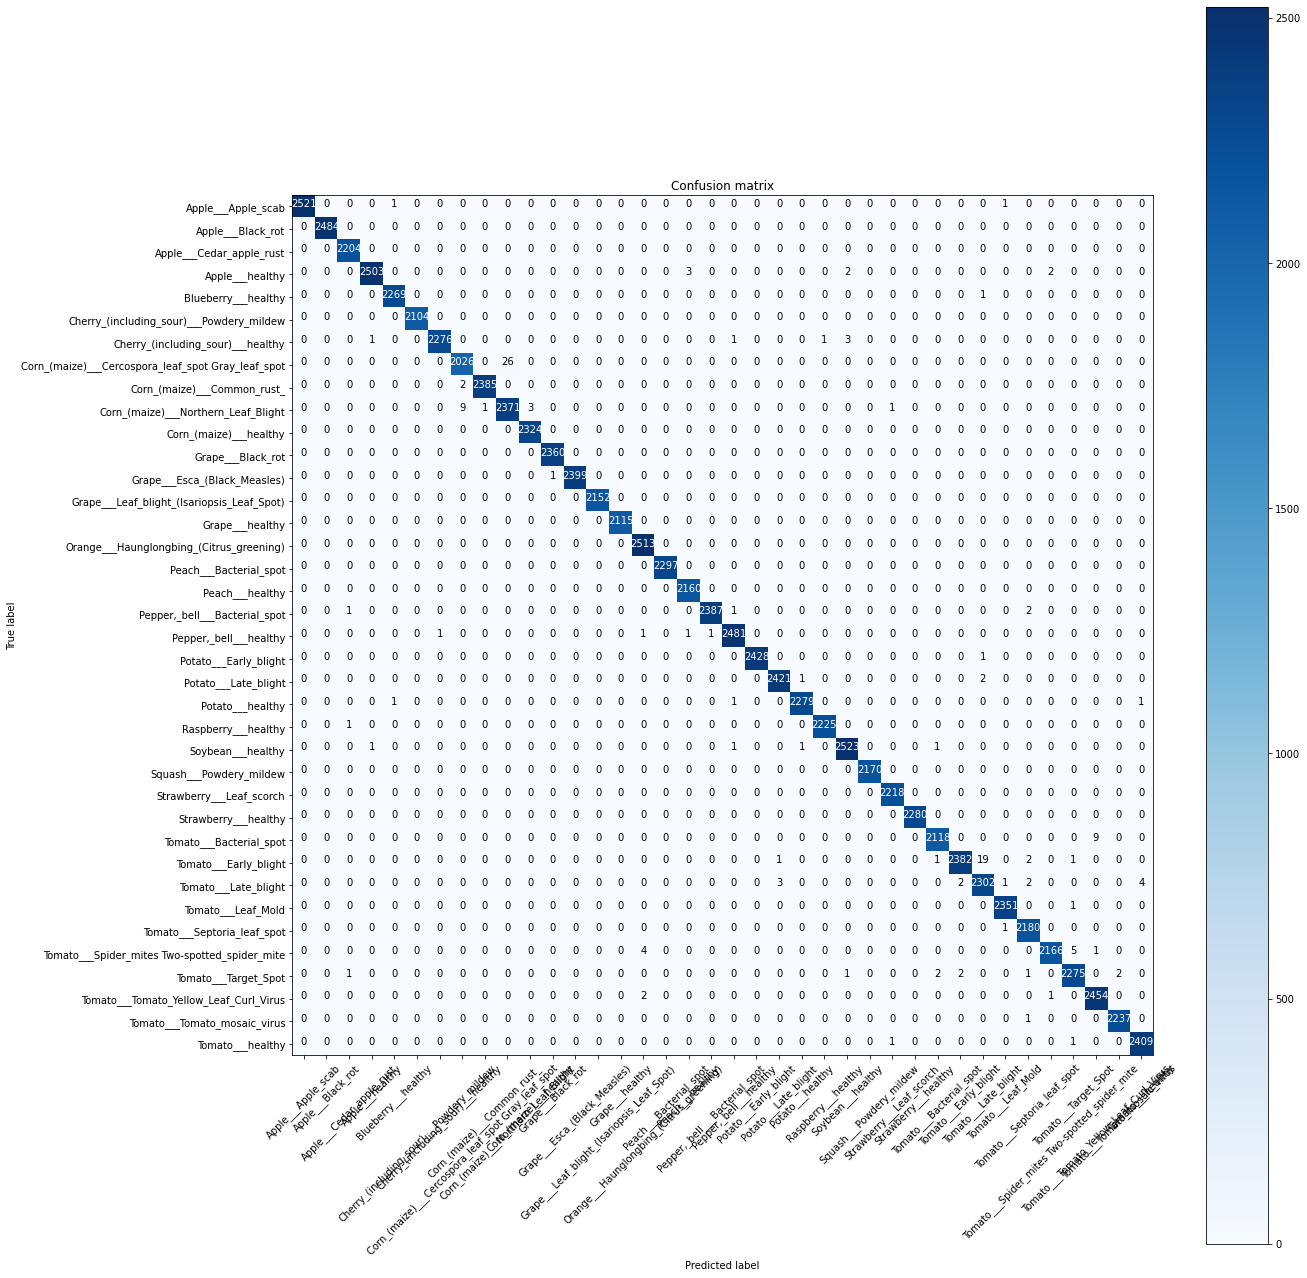

In [ ]:
plt.figure(figsize=(19,19))
plot_confusion_matrix(cm, data.classes)

In [ ]:
from sklearn import metrics

y_true = true_lb.tolist()

y_pred = data_preds.argmax(dim=1).tolist()

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[2521    0    0 ...    0    0    0]
 [   0 2484    0 ...    0    0    0]
 [   0    0 2204 ...    0    0    0]
 ...
 [   0    0    0 ... 2454    0    0]
 [   0    0    0 ...    0 2237    0]
 [   0    0    0 ...    0    0 2409]]
              precision    recall  f1-score   support

         0.0      1.000     0.999     1.000      2523
         1.0      1.000     1.000     1.000      2484
         2.0      0.999     1.000     0.999      2204
         3.0      0.999     0.997     0.998      2510
         4.0      0.999     1.000     0.999      2270
         5.0      1.000     1.000     1.000      2104
         6.0      1.000     0.997     0.998      2282
         7.0      0.995     0.987     0.991      2052
         8.0      1.000     0.999     0.999      2387
         9.0      0.989     0.994     0.992      2385
        10.0      0.999     1.000     0.999      2324
        11.0      1.000     1.000     1.000      2360
        12.0      1.000     1.000     1.000      2400
        13.0   